In [2]:
library(tidyverse)
library(tidymodels)
library(themis)
library(dplyr)
options(repr.matrix.max.rows = 5)

players_url <- "https://raw.githubusercontent.com/elilyliu/Group-4-project/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/elilyliu/Group-4-project/refs/heads/main/sessions.csv"

players <- read_csv(players_url) |> rename(age = Age)
sessions <- read_csv(sessions_url)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Figure 1: Player Dataset


experience,subscribe,hashedEmail,played_hours,name,gender,age,contributor_type
<fct>,<lgl>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<fct>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,High
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,High
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,Low
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,Low
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,High


experience,average_played_hours,average_age
<fct>,<dbl>,<dbl>
Beginner,1.2485714,21.65714
Amateur,6.0174603,20.25397
Regular,18.7257143,20.60000
Pro,2.7846154,16.92308
Veteran,0.6479167,20.95833


contributor_type,count,average_age
<fct>,<int>,<dbl>
High,25,19.84000
Low,152,20.57895
Medium,17,21.00000


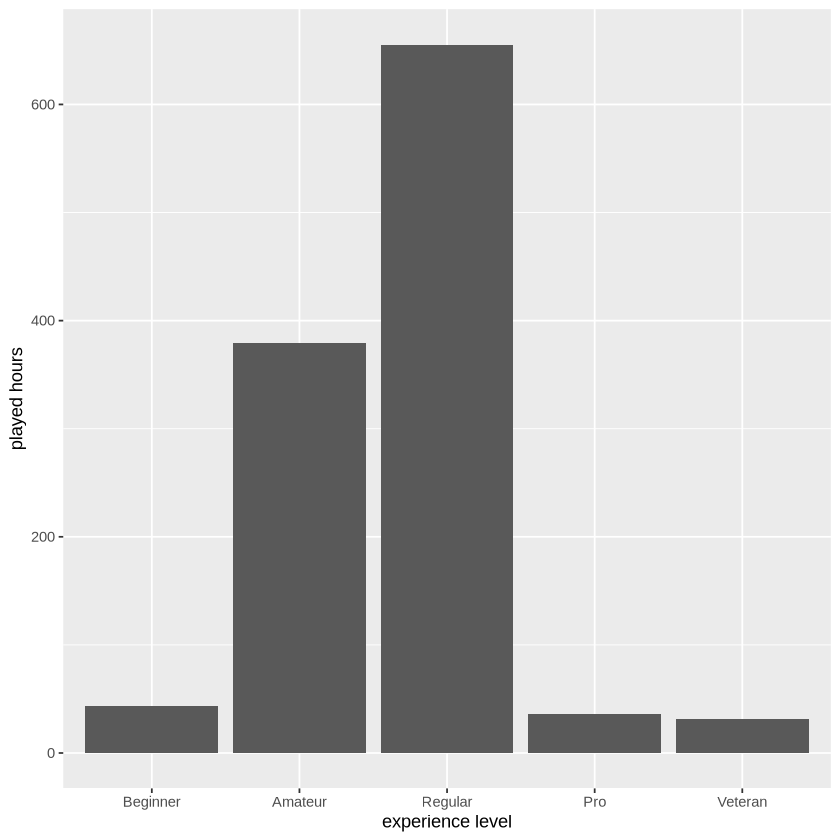

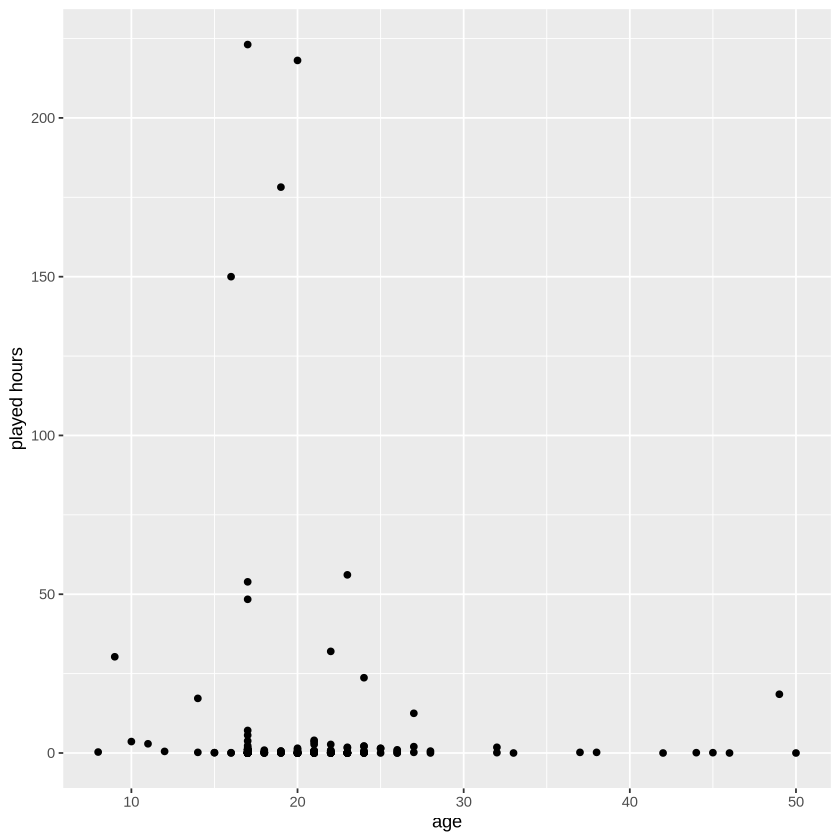

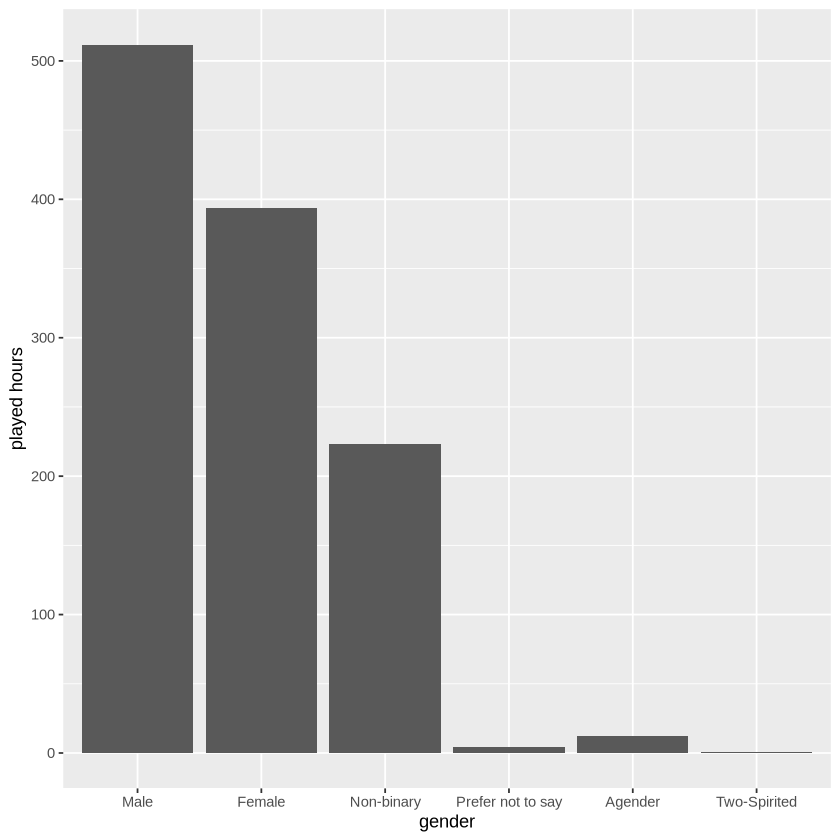

In [3]:
players <- players |>
    mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")),
           name = as_factor(name),
           gender = as_factor(gender),
           contributor_type = case_when(
              played_hours > 2 ~ "High",
              played_hours <= 2 & played_hours >= 1 ~ "Medium",
              played_hours < 1 ~ "Low")) |>
    mutate(contributor_type = factor(contributor_type)) |>
    drop_na()
cat("Figure 1: Player Dataset\n")
players


avg_experience <- players |>
    group_by(experience) |>
    summarize(average_played_hours = mean(played_hours, na.rm = TRUE),
             average_age = mean(age))
avg_experience

contributors <- players |>
    group_by(contributor_type) |>
    summarise(count = n(), 
             average_age = mean(age))
contributors

player_plot_experience <- ggplot(players, aes(x=experience, y=played_hours)) +
    geom_bar(stat="identity") +
    labs(x="experience level", y="played hours")
player_plot_experience

player_plot_age <- ggplot(players, aes(x=age, y=played_hours)) +
    geom_point() +
    labs(x="age", y="played hours")
player_plot_age

player_plot_gender <- ggplot(players, aes(x=gender, y=played_hours)) +
    geom_bar(stat="identity") +
    labs(x="gender", y="played hours")
player_plot_gender


In [4]:
selected_players <- players  |>
    mutate(experience_label = as.numeric(experience),
          gender_label = as.numeric(gender)) |>
    select(contributor_type, gender, gender_label, experience, experience_label, age)

selected_players

contributor_type,gender,gender_label,experience,experience_label,age
<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>
High,Male,1,Pro,4,9
High,Male,1,Veteran,5,17
Low,Male,1,Veteran,5,17
⋮,⋮,⋮,⋮,⋮,⋮
Low,Prefer not to say,4,Amateur,2,17
High,Male,1,Amateur,2,17


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5185258,3,0.003718321,Preprocessor1_Model01
2,accuracy,multiclass,0.5261016,3,0.010151210,Preprocessor1_Model02
3,accuracy,multiclass,0.4445908,3,0.005705512,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,accuracy,multiclass,0.3182916,3,0.011608563,Preprocessor1_Model09
10,accuracy,multiclass,0.3186210,3,0.008370276,Preprocessor1_Model10


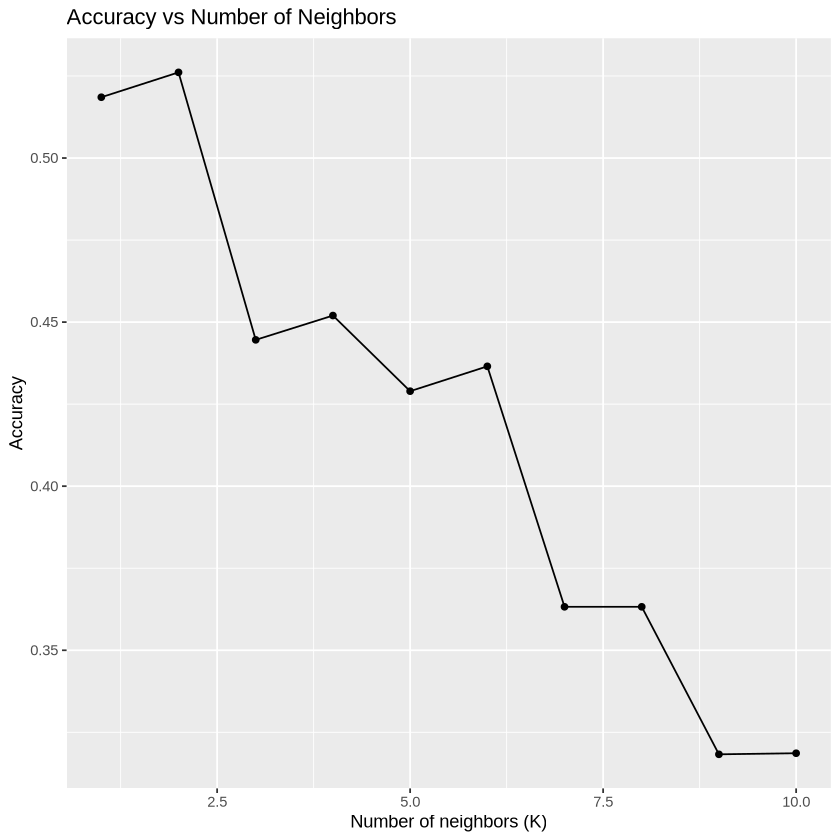

In [39]:
set.seed(2) 
player_split <- initial_split(selected_players, prop = 0.7, strata = contributor_type)  
player_train <- training(player_split)   
player_test <- testing(player_split)

player_recipe <- recipe(contributor_type ~ experience_label + age + gender_label, data = player_train) |>
    step_normalize(all_predictors()) |>
    step_upsample(contributor_type, over_ratio = 1, skip = TRUE)


knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

## use 3 fold because of lack of data
player_vfold <- vfold_cv(player_train, v = 3, strata = contributor_type)

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
cross_val_plot <- ggplot(knn_results, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Number of neighbors (K)", y="Accuracy", title = "Accuracy vs Number of Neighbors")

knn_results

cross_val_plot

In [40]:
set.seed(1) 

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode("classification")

player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_train)

player_predictions <- predict(player_fit, player_test) |>
    bind_cols(player_test)

mnist_metrics <- player_predictions |>
    metrics(truth = contributor_type, estimate = .pred_class)


mnist_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.55932203
kap,multiclass,-0.06973501


          Truth
Prediction High Low Medium
    High      2  11      0
    Low       5  31      6
    Medium    0   4      0

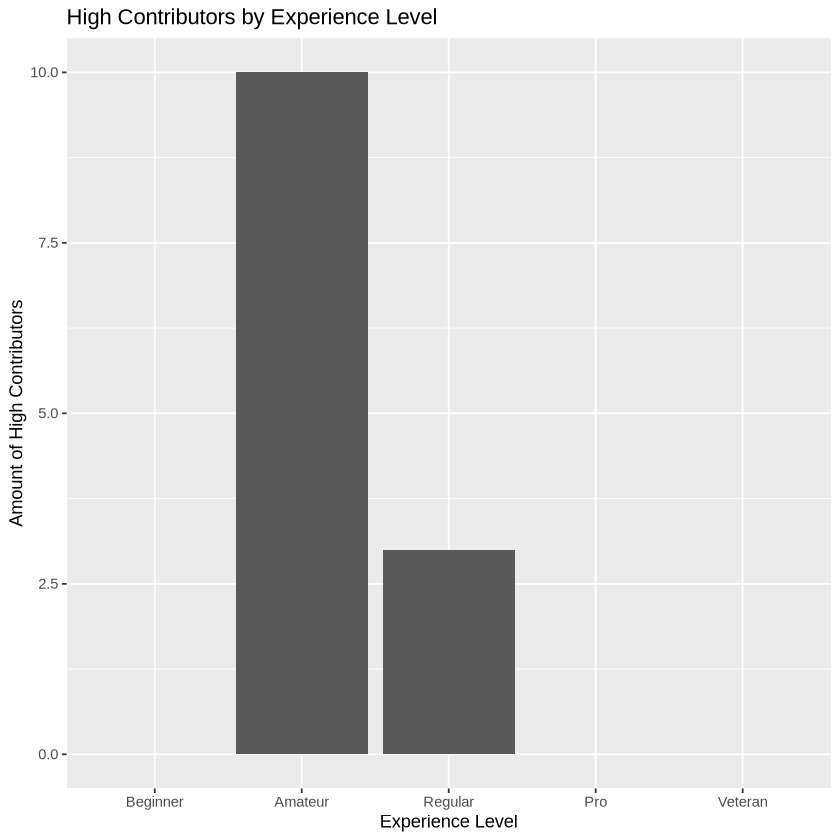

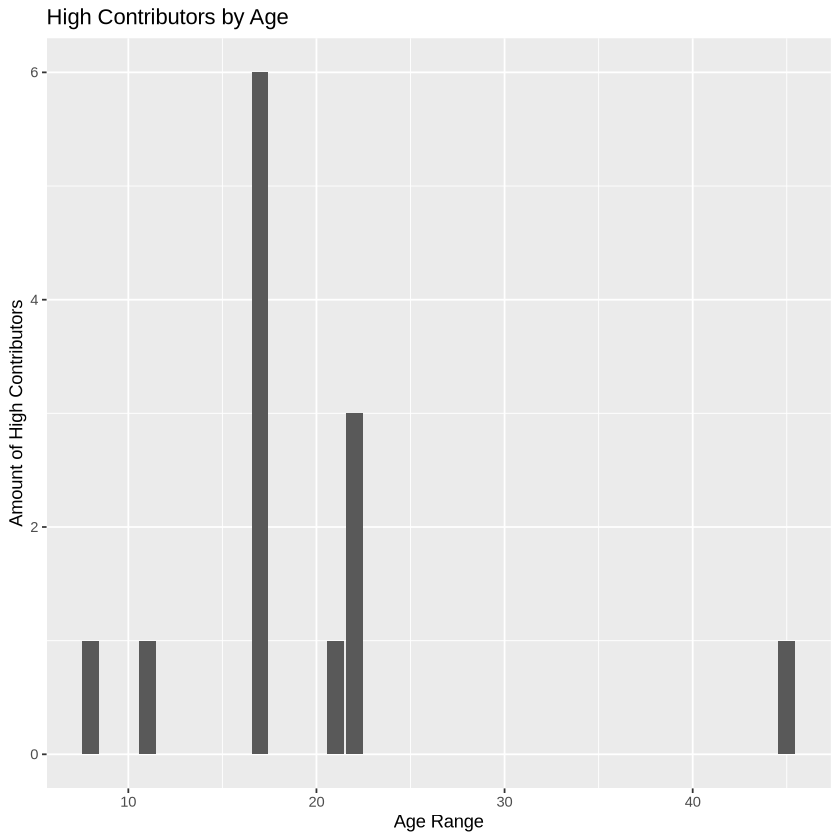

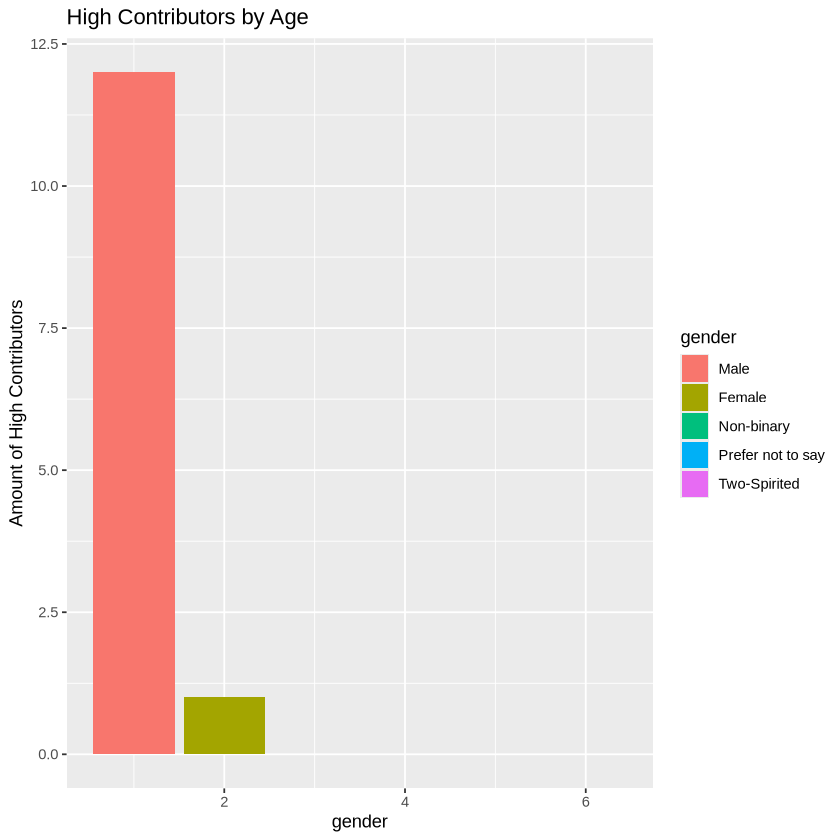

In [42]:
player_mat <- player_predictions |> 
      conf_mat(truth = contributor_type, estimate = .pred_class)
player_mat

contributor_summary <- player_predictions |>
  group_by(experience_label, age, gender_label, experience, gender, .pred_class) |>
  summarise(count = n(), .groups = "drop") |>
  pivot_wider(names_from = .pred_class, values_from = count, values_fill = 0)

ggplot(contributor_summary, aes(x = experience, y = High)) +
    geom_bar(stat = "identity") +
    labs(title = "High Contributors by Experience Level", 
         x = "Experience Level", 
         y = "Amount of High Contributors")

ggplot(contributor_summary, aes(x = age, y = High)) +
    geom_bar(stat = "identity") +
    labs(title = "High Contributors by Age", 
         x = "Age Range", 
         y = "Amount of High Contributors") 

ggplot(contributor_summary, aes(x = gender_label, y = High, fill = gender)) +
    geom_bar(stat = "identity") +
    labs(title = "High Contributors by Age", 
         x = "gender", 
         y = "Amount of High Contributors") 
